In [1]:
import pickle
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = np.copy(img)  # Delete this line
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undst = cv2.undistort(undist, mtx, dist, None, mtx)
    return undst

In [4]:
objpoints = []
imgpoints = []
images = glob.glob('./camera_cal/calibration*.jpg')
nx=9
ny=6
for i, fname in enumerate(images):
    #print(fname)
    #print(i)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(ret)
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#undistorted = cal_undistort(img, objpoints, imgpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#print(dist)
#print(mtx)

In [5]:
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
org_img = mpimg.imread('./camera_cal/calibration2.jpg')
undistorted = undistort(org_img)
img_size = (img.shape[1], img.shape[0])
print(img_size)

(1280, 720)


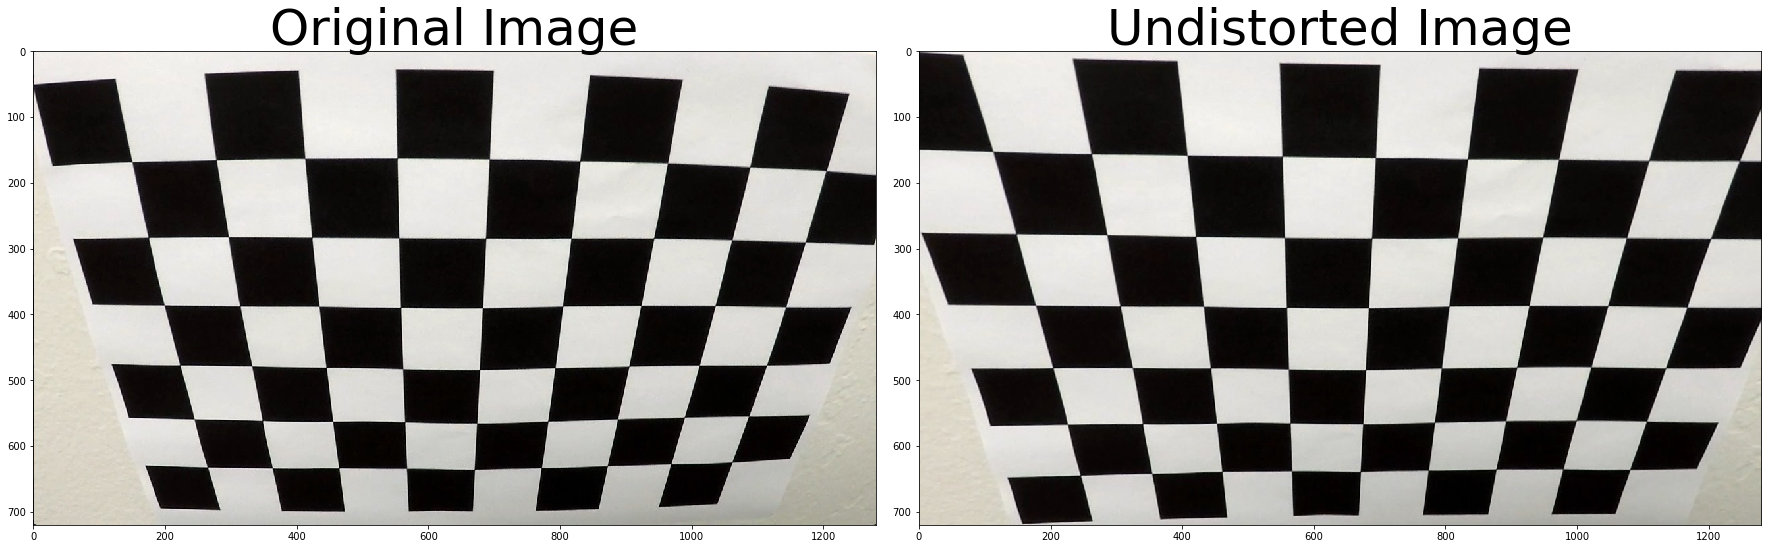

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(org_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


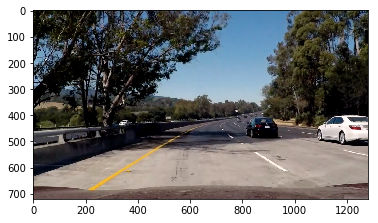

In [8]:
test_img = mpimg.imread('./test_images/test5.jpg')
plt.imshow(test_img)

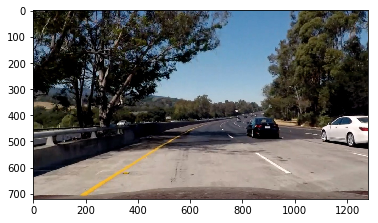

In [9]:
undistorted_img = cal_undistort(test_img, objpoints, imgpoints)
plt.imshow(undistorted_img)

In [10]:
def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grdir=np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(grdir)
    binary_output[(grdir >= thresh[0]) & (grdir <= thresh[1])] = 1
    return binary_output

def hls_sthresh_s(img, thresh=(125, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return binary_output
def hls_sthresh_h(img, thresh=(125, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,0] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return binary_output
def hls_sthresh_l(img, thresh=(125, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,1] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    return binary_output

In [11]:
def thresholded(undistorted_img):
    gradx = abs_sobel_thresh(undistorted_img, orient='x', thresh=(10, 255))
    grady = abs_sobel_thresh(undistorted_img, orient='y', thresh=(60, 255))
    mag_binary = mag_thresh(undistorted_img, sobel_kernel=3, mag_thresh=(40, 255))
    dir_binary = dir_threshold(undistorted_img, sobel_kernel=3, thresh=(.65, 1.05))
    hls_binary_s = hls_sthresh_s(undistorted_img, thresh=(110, 230))
    #hls_binary_h = hls_sthresh_h(undistorted_img, thresh=(120, 200))
    #hls_binary_l = hls_sthresh_l(undistorted_img, thresh=(90, 255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | ((hls_binary_s==1))] = 1
    return combined

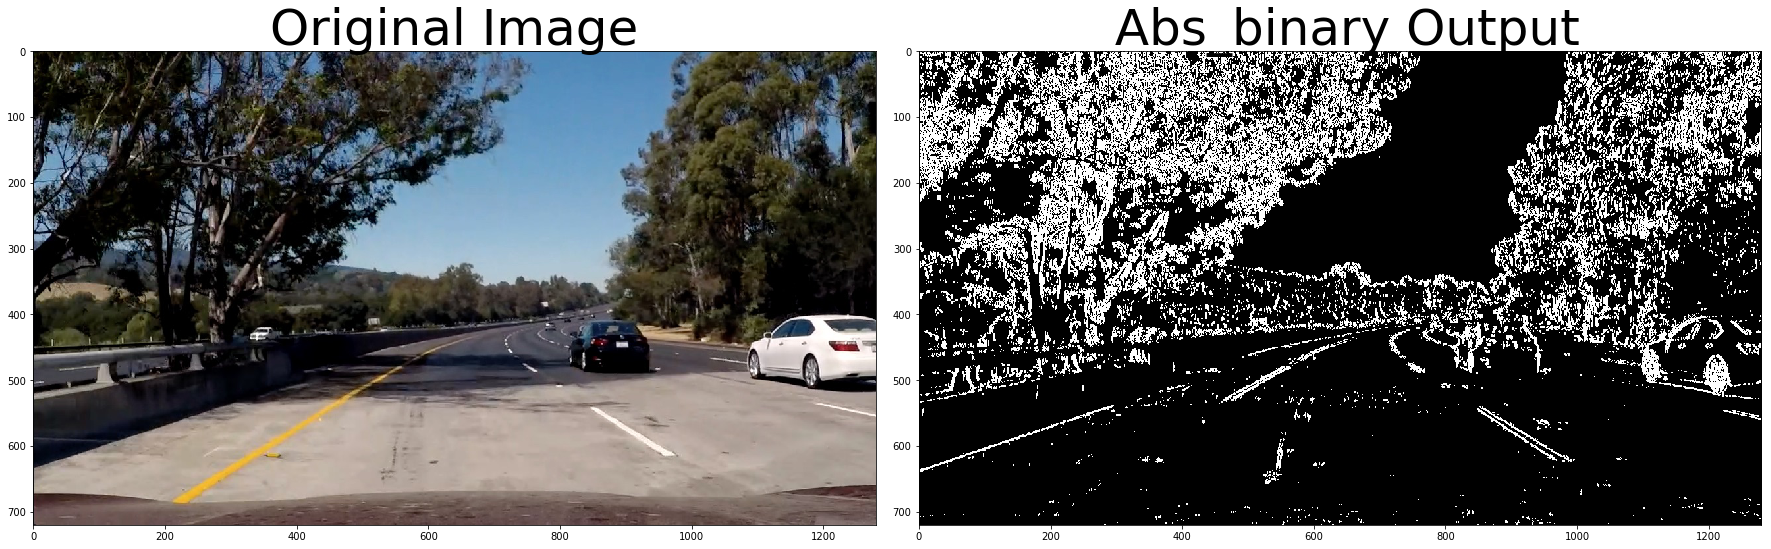

In [12]:
abs_binary = abs_sobel_thresh(undistorted_img, orient='x', thresh=(10, 255))
#print(thresh)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(abs_binary, cmap='gray')
ax2.set_title(' Abs_binary Output', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

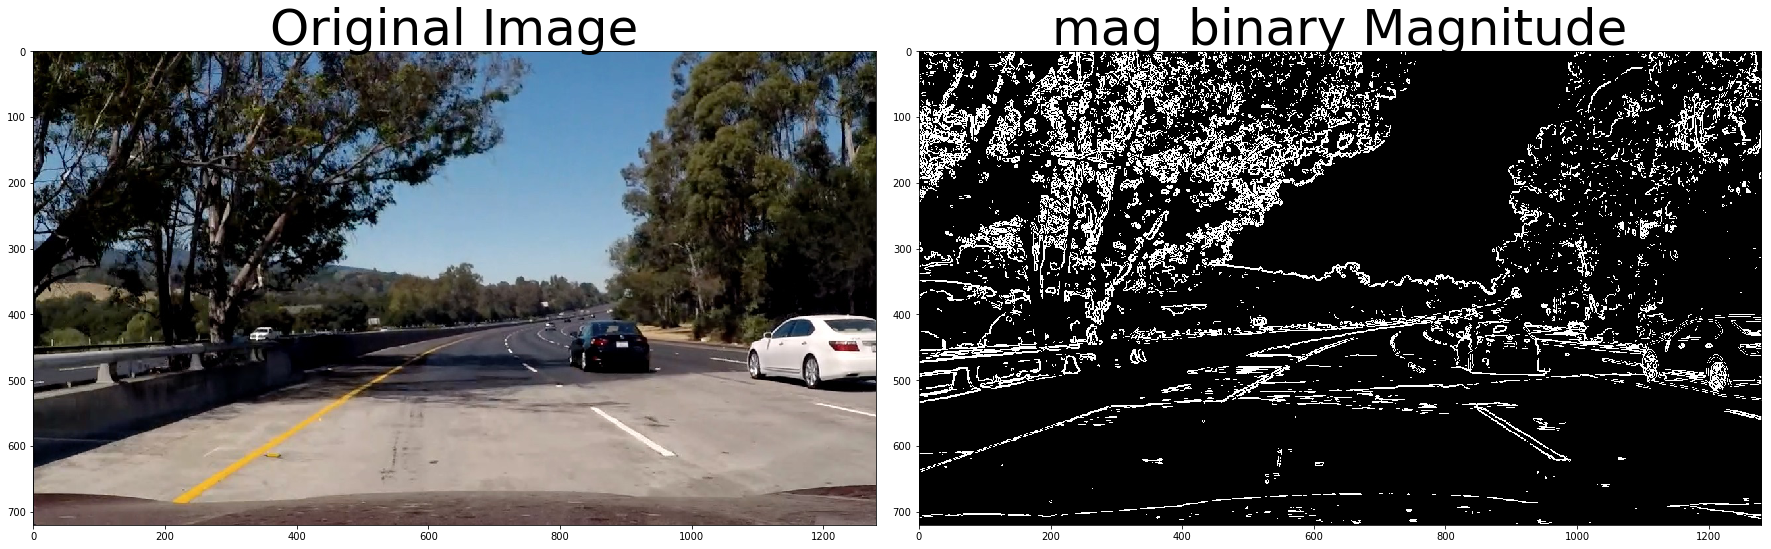

In [13]:
mag_binary = mag_thresh(undistorted_img, sobel_kernel=3, mag_thresh=(30, 100))
#print(mag_binary)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('mag_binary Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

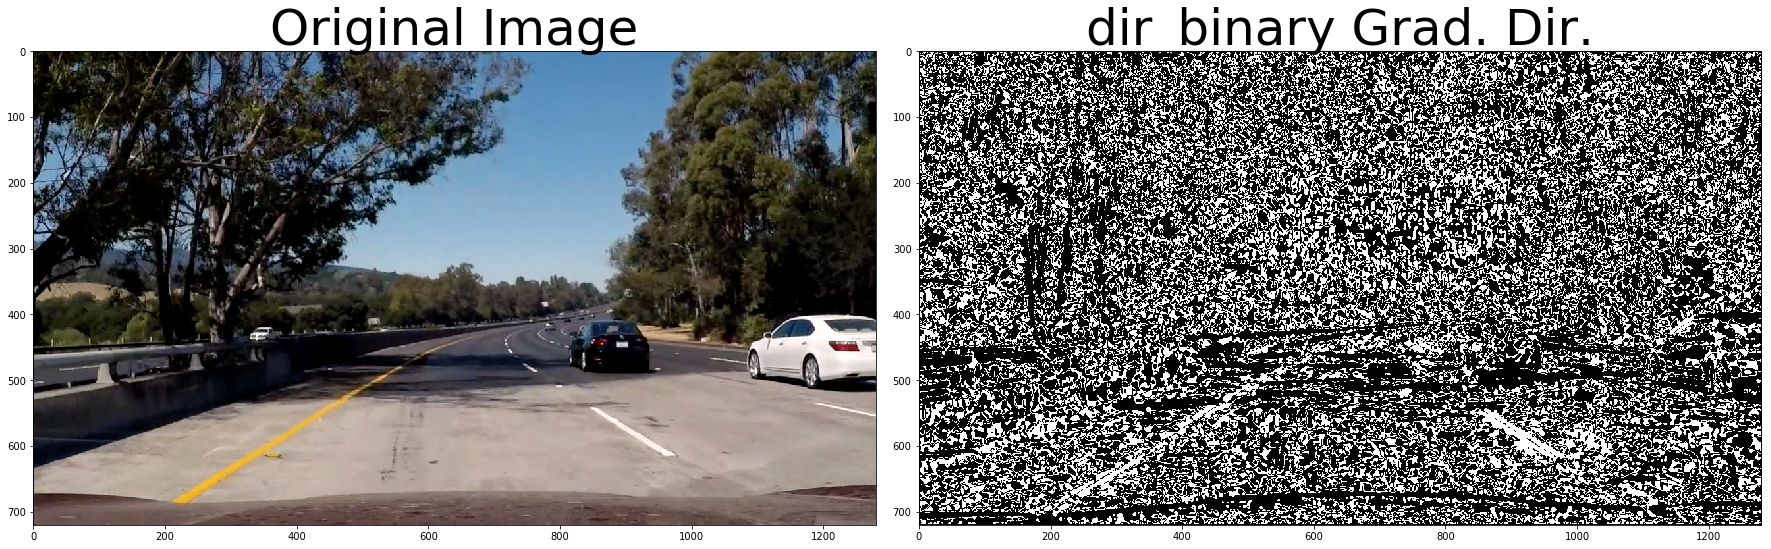

In [14]:
dir_binary = dir_threshold(undistorted_img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('dir_binary Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

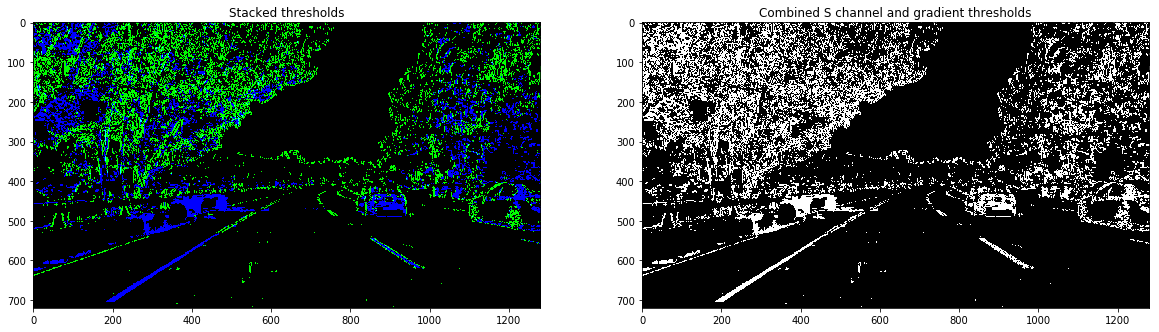

In [15]:
hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

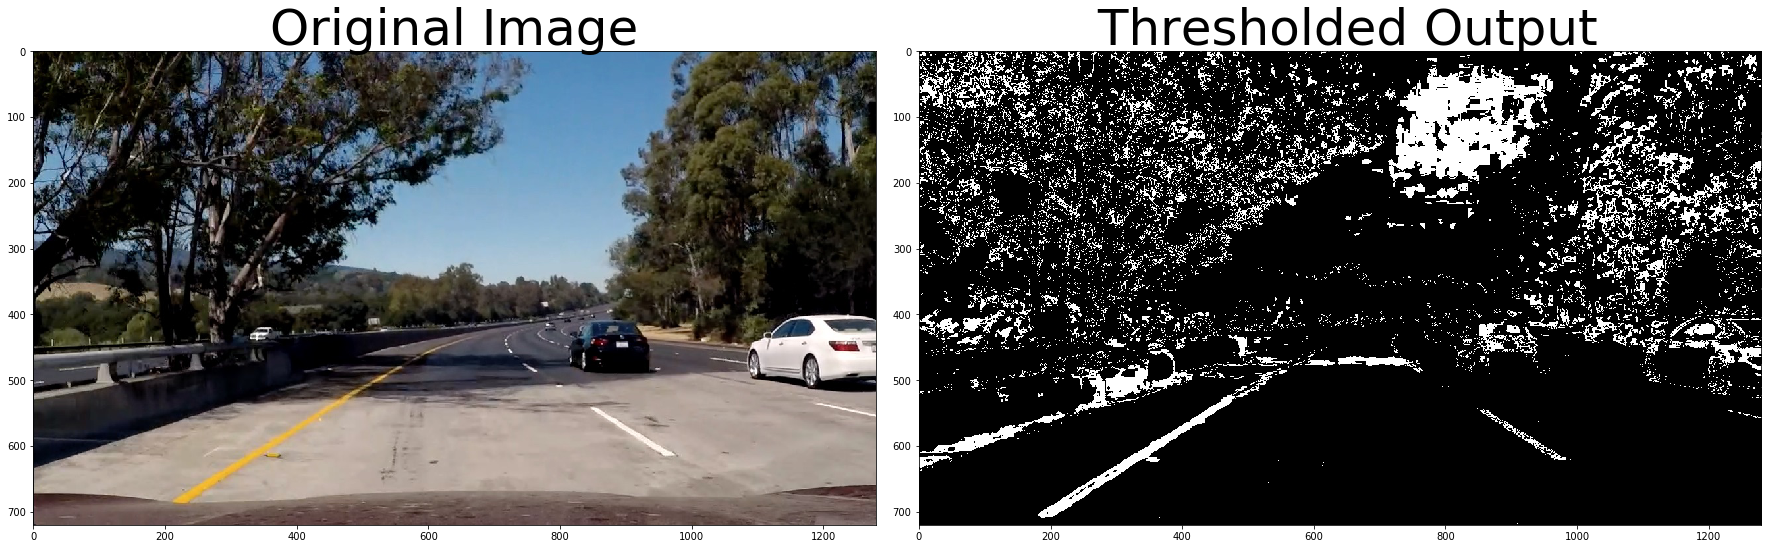

In [16]:
thresh_out = thresholded(undistorted_img)
#print(thresh)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresh_out, cmap='gray')
ax2.set_title(' Thresholded Output', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [17]:
src = np.float32([(520,510),(807,510),(1150,699),(258,679)])
dst = np.float32([(260,0), (780,0),(780,720), (200,720)])
def unwarp_img(img):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size=(gray.shape[1],gray.shape[0])
    #print(img_size)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

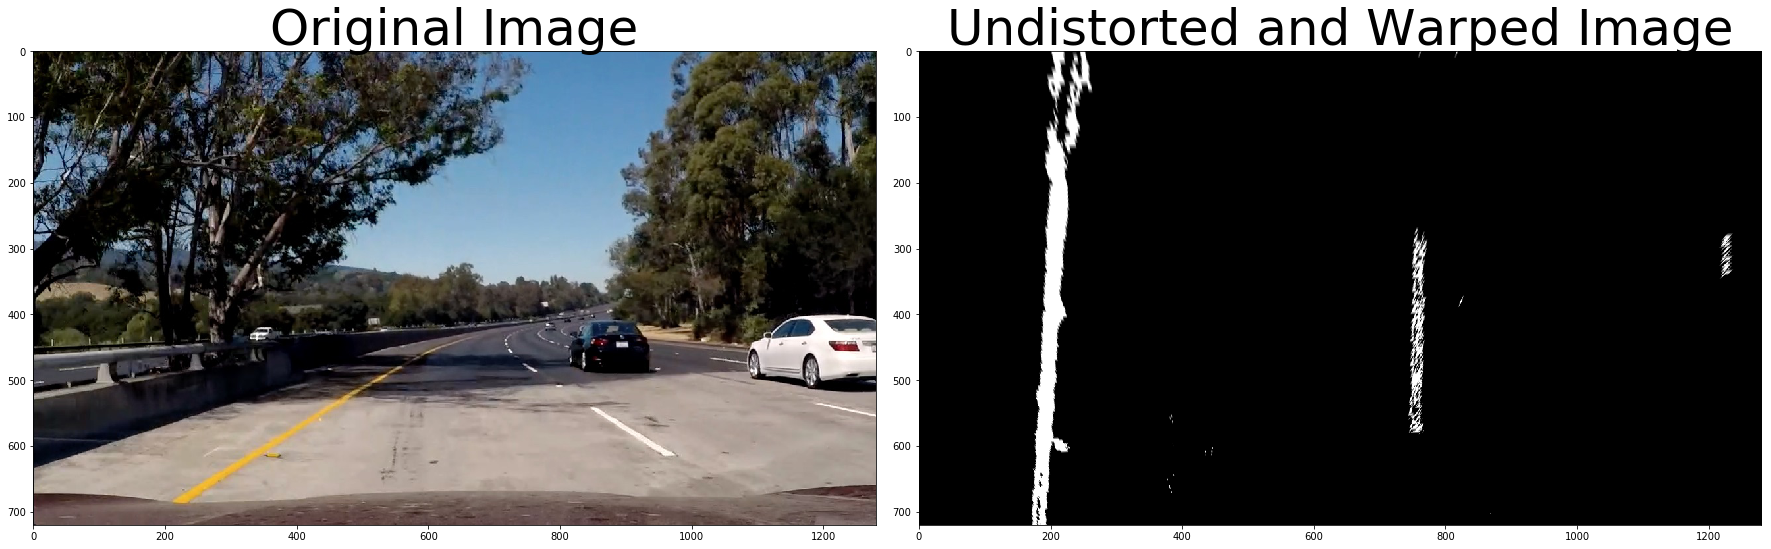

In [18]:
#plt.imshow(thresh_out, cmap='gray')
top_down, perspective_M = unwarp_img(thresh_out)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#src = np.float32([(580,464),(707,464),(258,679),(1050,679)])
#dst = np.float32([(260,0), (780,0), (200,720),(780,720)])

In [19]:
def pipeline(img):
    undistorted_img=undistort(img)
    thresholded_img=thresholded(undistorted_img)
    top_down2, perspective_M2 = unwarp_img(thresholded_img)
    wraped_top = top_down2
    warpedtop =np.dstack((wraped_top,wraped_top,wraped_top))*255
    return warpedtop


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


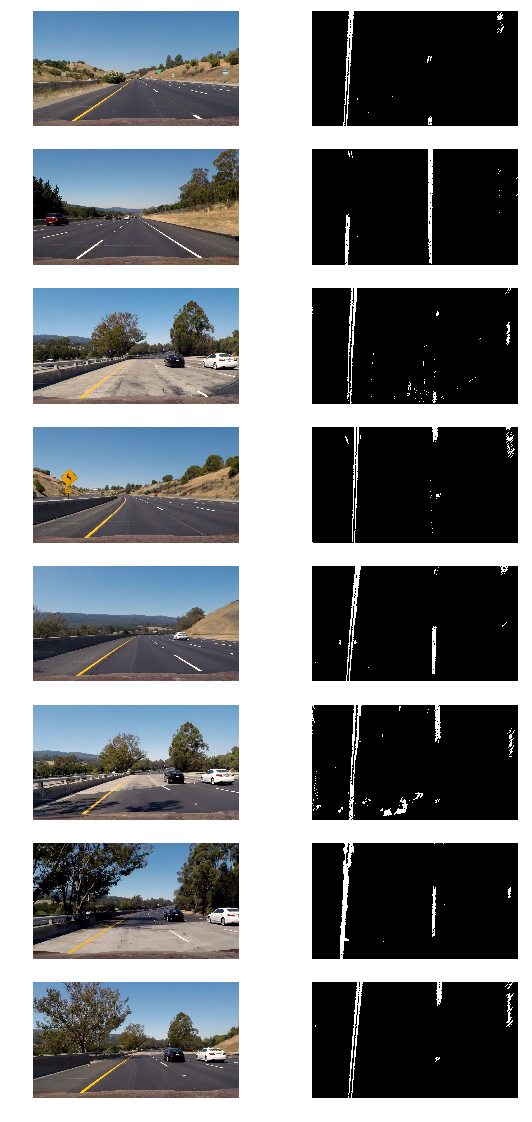

In [20]:
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1
 

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:11<00:00,  3.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 6min 12s


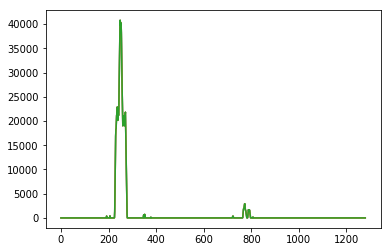

In [22]:
img_hist=img_bin
#plt.imshow(img_hist)
histogram = np.sum(img_hist[img_hist.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [23]:
histogram = np.sum(img_bin[img_bin.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((img_bin, img_bin, img_bin))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(img_bin.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = img_bin.shape[0] - (window+1)*window_height
    win_y_high = img_bin.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

error: C:\ci\opencv_1512684736357\work\modules\core\src\matrix.cpp:1168: error: (-215) cn <= 4 in function cv::scalarToRawData


In [ ]:
ploty = np.linspace(0, img_bin.shape[0]-1, img_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
       # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(img_bin, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(img_bin)
    r_points = np.zeros_like(img_bin)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,img_bin,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,img_bin,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((img_bin, img_bin, img_bin))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((img_bin,img_bin,img_bin)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()